## Import

In [ ]:
import mne
import numpy as np
import scipy
import os
import math
from scipy import signal as sg
from matplotlib import pyplot as plt
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs

## Load Data

In [ ]:
directory_path = "D:/EEG RESEARCH DATA"
os.chdir(directory_path)

raw = mne.io.read_raw_brainvision("enter file name here")

# Reconstruct the original events from our Raw object
events, event_ids = mne.events_from_annotations(raw)

Extracting parameters from 20231019_B68_stroopv1/20231019_B68_stroopv1_0001.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_channel_types({'ECG':'ecg'})
raw.set_channel_types({'vEOG':'eog'})
raw.set_channel_types({'hEOG':'eog'})

<RawBrainVision | 20231019_B68_stroopv1_0001.eeg, 67 x 958600 (958.6 s), ~60 kB, data not loaded>

In [ ]:
raw.set_montage(montage)
#fig = raw.plot_sensors(show_names=True)

<RawBrainVision | 20231019_B68_stroopv1_0001.eeg, 67 x 958600 (958.6 s), ~83 kB, data not loaded>

### Segment Grouping

In [ ]:
fs = 1000

trg0 = events[3,0] #Experiment Begin 
trg1 = events[4,0] #Task Begin
trg2 = events[-2,0] #Task End
trg3 = events[-1,0] #Experiment End

tmin = trg0/fs
tmax = trg3/fs

# #Segment in Samples
# seg1 = trg1 - trg0
# seg2 = trg2 - trg0
# seg3 = trg3 - trg0

# #Segment in ms
# newseg1 = int(seg1/fs)
# newseg2 = int(seg2/fs)
# newseg3 = int(seg3/fs)

## ECG Analysis

### Using My Pan Tompkins Algorithm

In [ ]:
##Testing only on ECG, T = 60 secs
#raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = 60, tmax = 120) #make a copy


#Testing only on ECG, T = Whole experiment actual time
raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = tmin, tmax = tmax) #make a copy

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [ ]:
mne_ecg, mne_time = raw_ecg[:]
mne_ecg = -mne_ecg.T

####  Pan Tompkins Alogrithm

In [ ]:
class pan_tompkins_qrs():
    def bpf(self,x):
        
        
        
        y_filtered = None

        #Results will be delayed 16 Samples
        y = x.copy()

        #Low Pass Filter
        #y(n) = 2y(n-1) - y(n-2) + x(n) - 2x(n-6) + x(n-12)
        for n in range(len(x)):
            y[n] = x[n]

            if (n >= 1):
                y[n] += 2*y[n-1]
            if (n >= 2):
                y[n] -= y[n-2]
            if (n >= 6):
                y[n] -= 2*x[n-6]
            if (n >= 12):
                y[n] += x[n-12]
        
        y_filtered = y.copy()

        #High Pass Filter
        #y(n) = 32x(n-16) - y(n-1) - x(n) + x(n-32)
        for n in range(len(x)):
            y_filtered[n] = -1*y[n]

            if (n >= 1):
                y_filtered[n] -= y_filtered[n-1]
            if (n >= 16):
                y_filtered[n] += 32*y[n-16]
            if(n >= 32):
                y_filtered[n] += y[n-32]
        
        #Normalization
        max_val = max(max(y_filtered), -min(y_filtered))
        y_filtered = y_filtered/max_val

        return y_filtered
    
    def derivative(self,x,fs):
        
        #Results will be delayed for 2 samples
        y_derived = x.copy()
        
        #Derivative Filter
        #y(n) = [-x(n-2) - 2x(n-1) + 2x(n+1) + x(n+2)]/8
        for n in range(len(x)):
            y_derived[n] = 0

            if (n >= 1):
                y_derived[n] -= 2*x[n-1]
            if (n >= 2):
                y_derived[n] -= x[n-2]
            
            ###Not sure what this part is for###
            if (n >= 2 and n <= len(x)-2):
                y_derived[n] += 2*x[n+1]
            if (n >= 2 and n<= len(x)-3):
                y_derived[n] += x[n+2]
            ###Not sure what this part is for###

            ###Not sure why does it has to be times to "fs"###
            y_derived[n] = (y_derived[n]*fs)/8
            ###Not sure why does it has to be times to "fs"###
        
        return y_derived
    
    def squaring(self,x):
        
        y_squared = x.copy()

        for n in range(len(x)):
            y_squared[n] = x[n]**2

        return y_squared
    
    def moving_window_integration(self,x,fs):
        # Initialize result and window size for integration
        y = x.copy()
        win_size = round(0.150 * fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += x[j]/win_size
            y[j] = sum
        
        # Apply the moving window integration using the equation given
        for n in range(win_size,len(x)):  
            sum += x[n]/win_size
            sum -= x[n-win_size]/win_size
            y[n] = sum

        return y

    def solve(self,x,fs):

        # Convert the input signal into numpy array
        input_signal = x.copy()

        # Bandpass Filter
        global bpass
        bpass = self.bpf(input_signal.copy())

        # Derivative Function
        global der
        der = self.derivative(bpass.copy(),fs)

        # Squaring Function
        global sqr
        sqr = self.squaring(der.copy())

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr.copy(),fs)

        return mwin


In [ ]:
class heart_rate():
    def __init__(self,x,fs):
        #Initialize Variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False
        self.m_win = mwin
        self.b_pass = bpass
        self.fs = fs
        self.signal = x
        self.win_150ms = round(0.15*self.fs)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0

    def approx_peak(self):
        ###Change from the original code by making the size to (A x 1) instead of (A x )###
        slopes = sg.fftconvolve(self.m_win, np.full((25,1),1)/25, mode='same')
        ###Change from the original code by making the size to (A x 1) instead of (A x )###

        # for i in range(round(0.5*self.fs) + 1,len(slopes)-1):
        for i in range(0,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] <slopes[i]):
                self.peaks.append(i)

    def adjust_rr_interval(self, ind):
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.fs  

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1
        
        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2
    
    def searchback(self, peak_val, RRn, sb_win):
        # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

            # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None
    
            # If the max peak value is found
            if (x_max is not None):   
                # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

                # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

                # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

                # Find the x location of the max peak value in the search window
                if (len(coord) > 0):
                    for pos in coord:
                        if (win_rr[pos] == max(win_rr[coord])):
                            r_max = pos
                            break
                else:
                    r_max = None

                # If the max peak value is found
                if (r_max is not None):
                # Update the thresholds corresponding to bandpass filter
                    if self.b_pass[r_max] > self.Threshold_F2:                                                        
                        self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                        self.Threshold_F2 = 0.5 * self.Threshold_F1      

                        # Append the probable R peak location                      
                        self.r_locs.append(r_max)

    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            if (ind > 0 and 0.20 < RRn < 0.36):
                # Find the slope of current and last waveform detected        
                curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
                last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
            
                # If current waveform slope is less than half of last waveform slope
                if (curr_slope < 0.5*last_slope):  
                    # T Wave is found and update noise threshold                      
                    self.T_wave = True                             
                    self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
            
        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))

        # Initialize a window to searchback
        win_200ms = round(0.2*self.fs)
    
        for r_val in self.r_locs:
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

            # Find the x location of the max peak value
            if (len(coord) > 0):
                for pos in coord:
                    if (self.signal[pos] == max(self.signal[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

            # Append the peak location
            if (x_max is not None):   
                self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''

        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
                x_coord = np.asarray(self.b_pass == max_val).nonzero()
                self.probable_peaks.append(x_coord[0][0])
                
            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits
                self.adjust_rr_interval(ind)
                
                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.fs))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
                # Adjust threholds
                self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return self.result


#### Utilization of the Pan Tompkins Algorithm

In [ ]:
QRS_detector = pan_tompkins_qrs()
output = QRS_detector.solve(mne_ecg, fs)

In [ ]:
# Convert ecg signal to numpy array
signal = mne_ecg.copy()

# Find the R peak locations
hr = heart_rate(signal,fs)
result = hr.find_r_peaks()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

C:\Users\jeje_\AppData\Local\Temp\ipykernel_34792\2487238089.py:115: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
C:\Users\jeje_\AppData\Local\Temp\ipykernel_34792\2487238089.py:116: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
C:\Users\jeje_\AppData\Local\Temp\ipykernel_34792\2487238089.py:119: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (curr_slope < 0.5*las

In [ ]:
#####################################################Pre Process, Data Cleaning ECG
r_peak = np.unique(result) #Remove Duplicate R Peak
#####################################################Pre Process, Data Cleaning ECG#####################################################

##If there is any mistake on the detection, write code over here##

#####################################################Pre Process, Data Cleaning ECG#####################################################

result = r_peak.copy()
rri = np.diff(result[:])

Heart Rate 64.26580978920282 BPM


Text(0.5, 1.0, 'R Peak Locations')

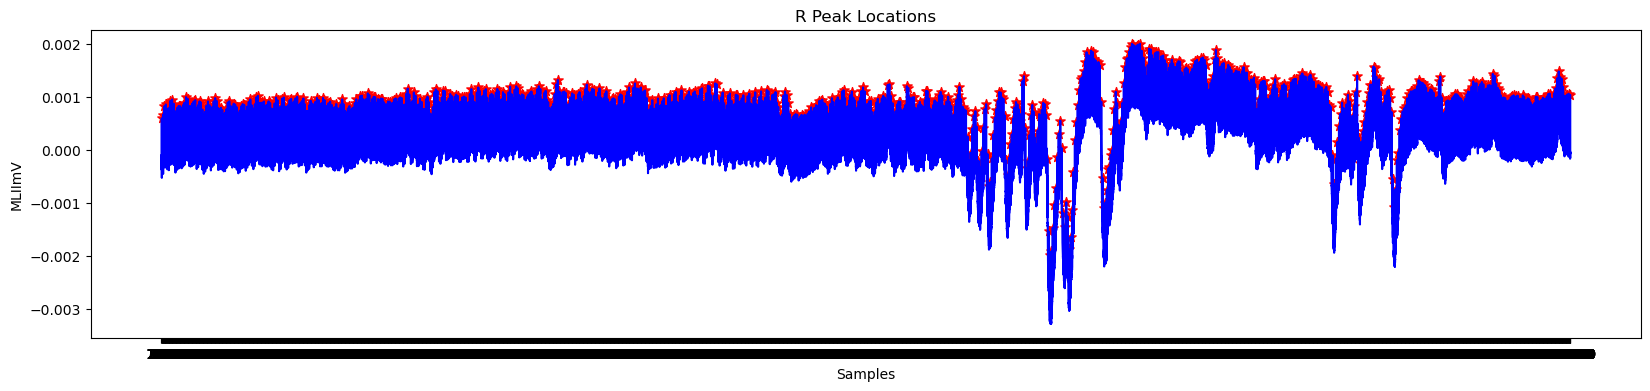

In [ ]:
# Calculate the heart rate
heartRate = (60*fs)/np.average(rri)
print("Heart Rate",heartRate, "BPM")

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')        
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

In [ ]:
############################### Segment Grouping if we remove the very first R-Peak ###############################
#Segment in Samples
seg1 = trg1 - trg0 - r_peak[0]
seg2 = trg2 - trg0 - r_peak[0]
seg3 = trg3 - trg0 - r_peak[0]

#Segment in ms
newseg1 = int(seg1/fs)
newseg2 = int(seg2/fs)
newseg3 = int(seg3/fs)

exp_duration = (len(mne_ecg) - r_peak[0] - (len(mne_ecg) - r_peak[-1]))/fs  #Tot duration - First Peak - (Tot Duration - Last peak) 
############################### Segment Grouping if we remove the very first R-Peak ###############################

#### Data Interpolation and STFT

Text(0.5, 0, 'Time [sec]')

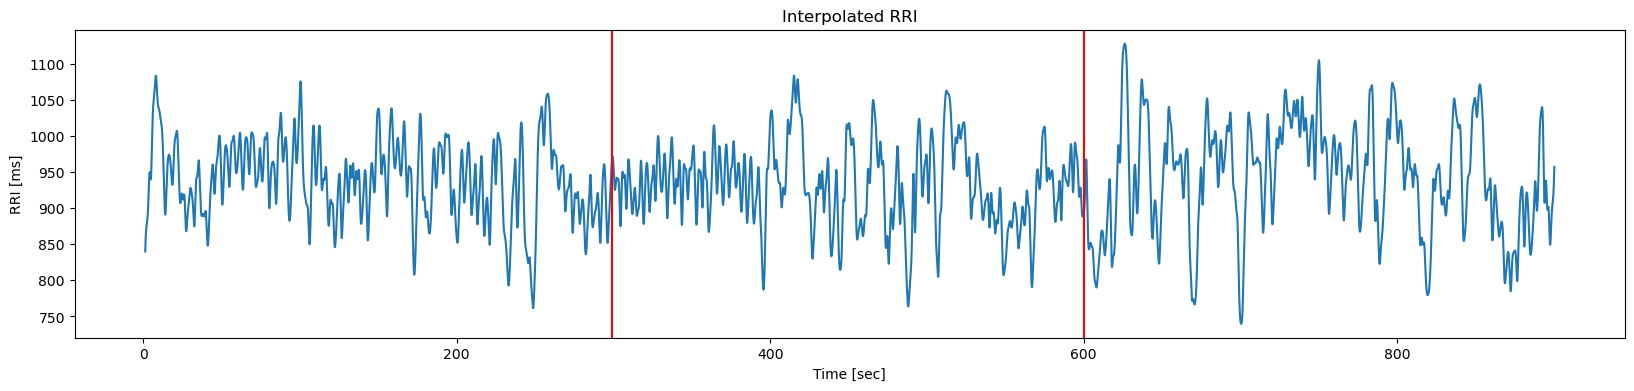

In [ ]:
# #Data Interpolation, Fs = 1000
# exp_duration = len(mne_ecg)/fs

x_vals = np.linspace(r_peak[1],r_peak[-1],int(exp_duration*fs))
splines = scipy.interpolate.splrep(r_peak[1:],rri)
y_vals = scipy.interpolate.splev(x_vals,splines)

plt.figure(figsize = (20,4),dpi = 100)
plt.plot(x_vals/fs,y_vals)
plt.axvline(x = newseg1, color = 'r')
plt.axvline(x = newseg2, color = 'r')

plt.title('Interpolated RRI')
plt.ylabel('RRI [ms]')
plt.xlabel('Time [sec]')

In [ ]:
y_firstrest = y_vals[:seg1] 
y_stress = y_vals[seg1:seg2]
y_secondrest = y_vals[seg2:]

#### Time Analysis

In [ ]:
#Measure SDNN
sdnn_full = np.std(y_vals)
sdnn_rest_1 = np.std(y_firstrest)
sdnn_test = np.std(y_stress)
sdnn_rest_2 = np.std(y_secondrest)
print("Standard Deviation during Experiment: ", sdnn_full)
print("Standard Deviation during First Rest: ", sdnn_rest_1)
print("Standard Deviation during CSWT: ", sdnn_test)
print("Standard Deviation during Second Rest: ", sdnn_rest_2)

Standard Deviation during Experiment:  62.618666942373174
Standard Deviation during First Rest:  53.64844171821438
Standard Deviation during CSWT:  55.08269363625606
Standard Deviation during Second Rest:  76.10188267692351


#### Frequency Analysis

##### PSD Measurement using Welch Method

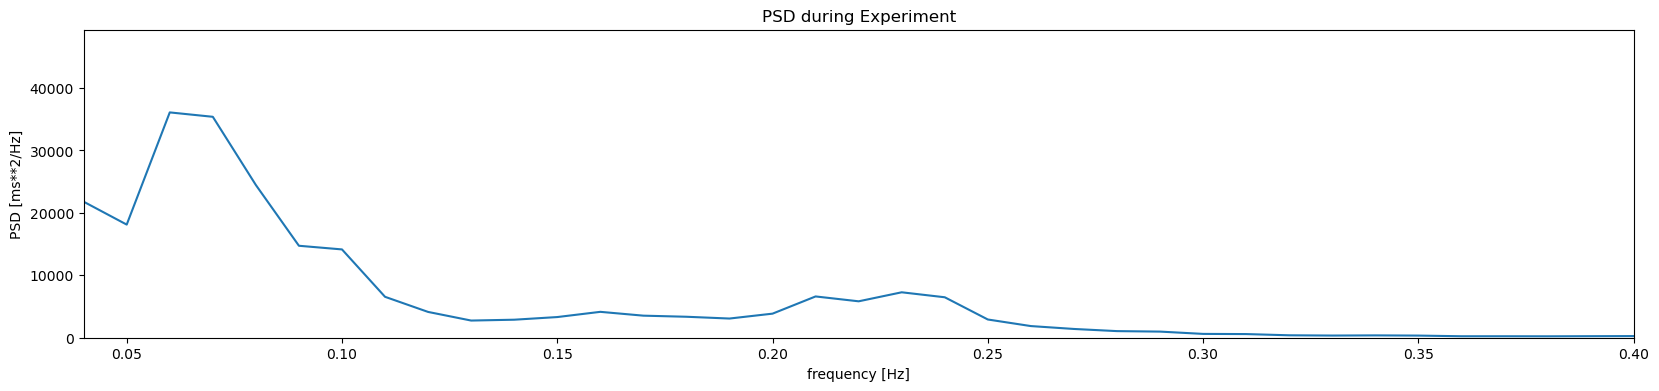

Absolute Power LF =  184335.41335373317 ms**2/Hz
Absolute Power HF =  59559.709218358796 ms**2/Hz
Total Power =  357840.3059807996 ms**2/Hz
LF/HF Ratio =  3.0949683229298453
Normalized Power LF =  51.51331760923096 %
Normalized Power HF =  16.64421481395518 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_vals,fs,nperseg = nperseg, noverlap=noverlap)

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Experiment')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')

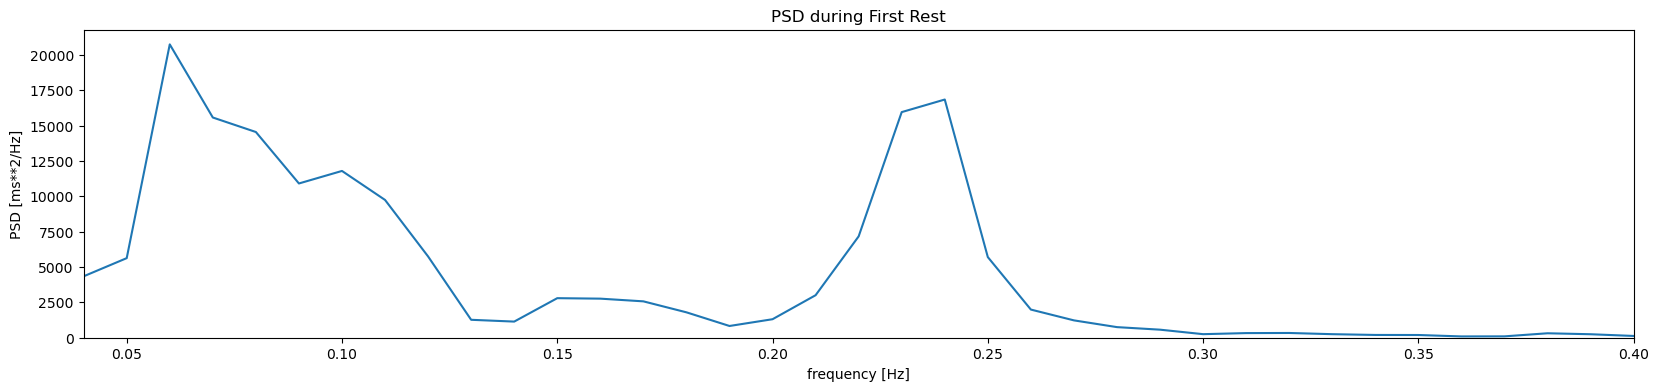

Absolute Power LF =  104277.06628794063 ms**2/Hz
Absolute Power HF =  67733.88682224082 ms**2/Hz
Total Power =  220036.65882106576 ms**2/Hz
LF/HF Ratio =  1.5395110362055975
Normalized Power LF =  47.39076972293918 %
Normalized Power HF =  30.783000971361847 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_firstrest,fs,nperseg = nperseg, noverlap=noverlap)

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during First Rest')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')

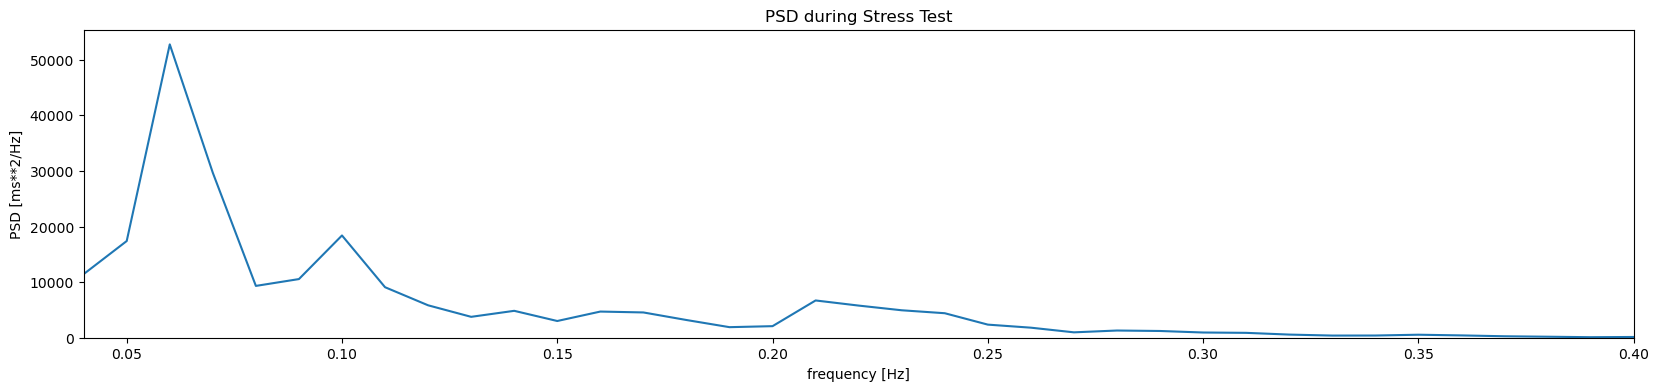

Absolute Power LF =  176014.62925761042 ms**2/Hz
Absolute Power HF =  53671.88414236118 ms**2/Hz
Total Power =  352790.935333336 ms**2/Hz
LF/HF Ratio =  3.279456871511033
Normalized Power LF =  49.892049831524794 %
Normalized Power HF =  15.213509976283568 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_stress,fs,nperseg = nperseg, noverlap=noverlap)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Stress Test')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')

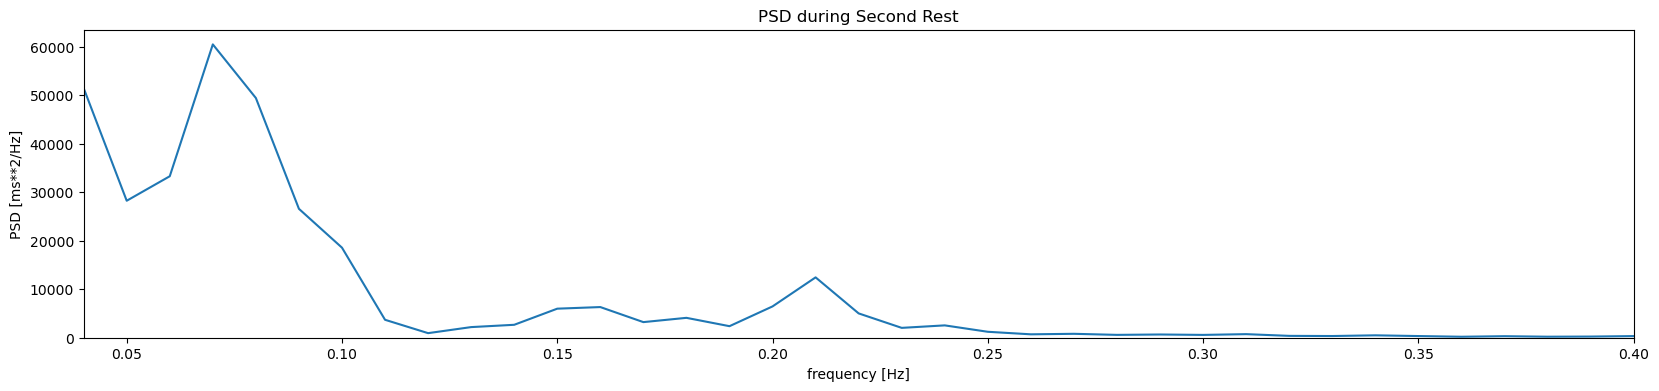

Absolute Power LF =  283448.1563010124 ms**2/Hz
Absolute Power HF =  58656.0802361212 ms**2/Hz
Total Power =  480468.6192171698 ms**2/Hz
LF/HF Ratio =  4.832374668746808
Normalized Power LF =  58.99410387359658 %
Normalized Power HF =  12.20809807135581 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_secondrest,fs,nperseg = nperseg, noverlap=noverlap)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Second Rest')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')

#### Time-Frequency Analysis

##### PSD Welch Over-time

In [ ]:
# Parameters for segmentation and analysis
segment_length = 10*fs  # seconds
overlap = int(segment_length*0.9)  # seconds

# Calculate LF/HF ratio over time
lfhf_ratio = []
hf_over_time = []
lf_over_time = []

for i in range(0, len(y_vals), segment_length - overlap):
    segment = y_vals[i:i + segment_length]

    # Compute PSD using Welch's method
    f_den, Pxx_den = sg.welch(segment, fs=fs, nperseg = 10000)

    idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
    idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))

    # Calculate LF and HF power
    abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
    abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
    lf_hf_ratio = abs_power_LF / abs_power_HF

    # Calculate LF/HF ratio
    if math.isnan(lf_hf_ratio) == False:
        lfhf_ratio.append(lf_hf_ratio)
    if math.isnan(abs_power_HF) == False:
        hf_over_time.append(abs_power_HF)
    if math.isnan(abs_power_LF) == False:
        lf_over_time.append(abs_power_LF)

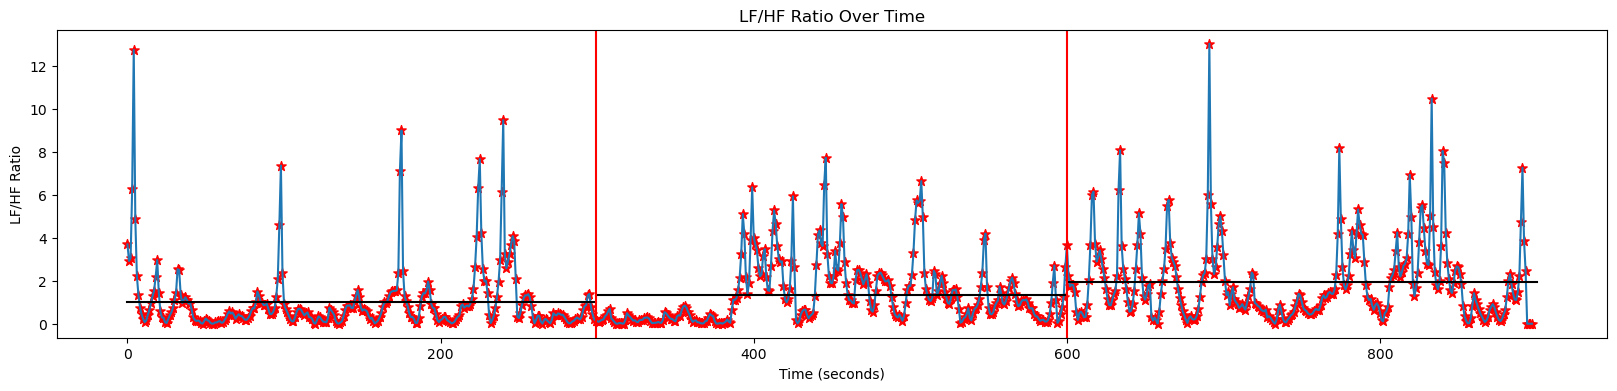

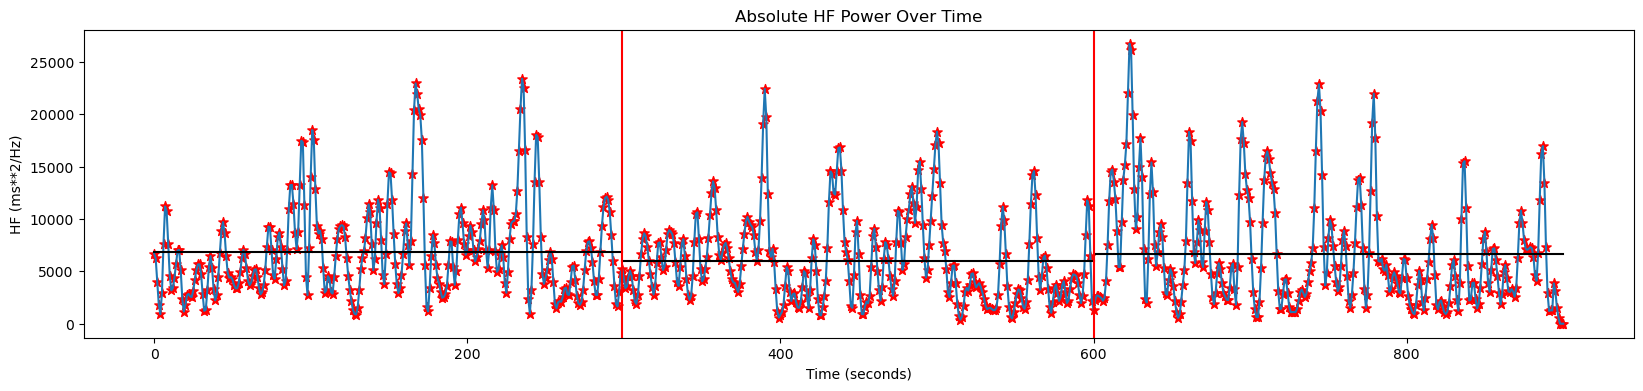

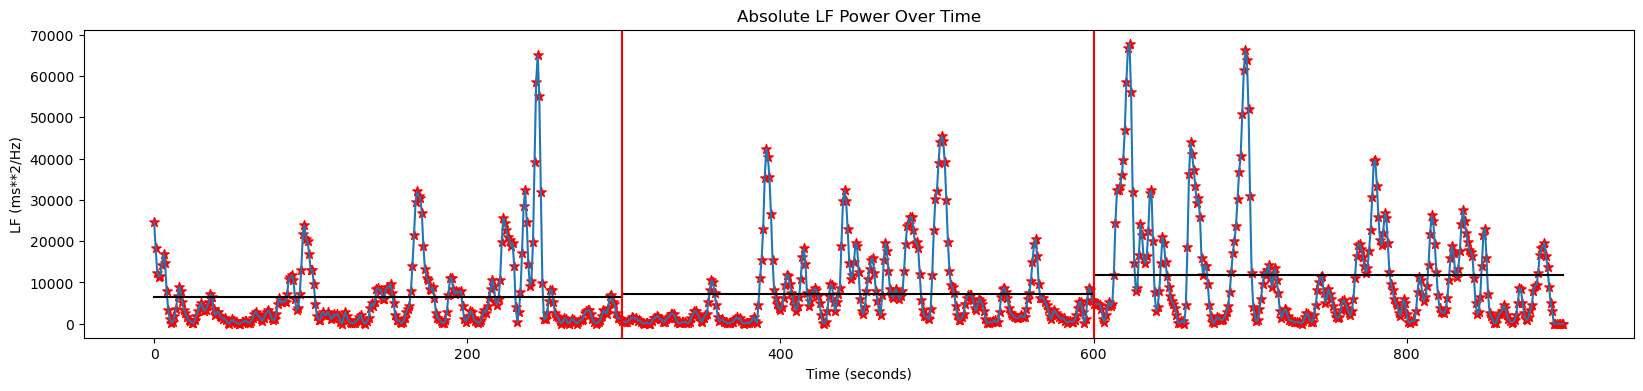

In [ ]:
# Plot LF/HF ratio over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(lfhf_ratio)*(segment_length - overlap), segment_length - overlap)/fs, lfhf_ratio)
plt.plot((0, newseg1), (np.average(lfhf_ratio[0:newseg1]),np.average(lfhf_ratio[0:newseg1])), 'k-')
plt.plot((newseg1, newseg2), (np.average(lfhf_ratio[newseg1:newseg2]),np.average(lfhf_ratio[newseg1:newseg2])), 'k-')
plt.plot((newseg2, newseg3), (np.average(lfhf_ratio[newseg2:]),np.average(lfhf_ratio[newseg2:])), 'k-')
plt.scatter(np.arange(0, len(lfhf_ratio)*(segment_length - overlap), segment_length - overlap)/fs, lfhf_ratio, color = 'red', s = 50, marker= '*')
plt.axvline(x = newseg1, color = 'r')
plt.axvline(x = newseg2, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('LF/HF Ratio')
plt.title('LF/HF Ratio Over Time')
plt.show()

# Plot HF over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(hf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, hf_over_time)
plt.plot((0, newseg1), (np.average(hf_over_time[0:newseg1]),np.average(hf_over_time[0:newseg1])), 'k-')
plt.plot((newseg1, newseg2), (np.average(hf_over_time[newseg1:newseg2]),np.average(hf_over_time[newseg1:newseg2])), 'k-')
plt.plot((newseg2, newseg3), (np.average(hf_over_time[newseg2:]),np.average(hf_over_time[newseg2:])), 'k-')
plt.scatter(np.arange(0, len(hf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, hf_over_time, color = 'red', s = 50, marker ='*')
plt.axvline(x = newseg1, color = 'r')
plt.axvline(x = newseg2, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('HF (ms**2/Hz)')
plt.title('Absolute HF Power Over Time')
plt.show()

# Plot LF over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(lf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, lf_over_time)
plt.plot((0, newseg1), (np.average(lf_over_time[0:newseg1]),np.average(lf_over_time[0:newseg1])), 'k-')
plt.plot((newseg1, newseg2), (np.average(lf_over_time[newseg1:newseg2]),np.average(lf_over_time[newseg1:newseg2])), 'k-')
plt.plot((newseg2, newseg3), (np.average(lf_over_time[newseg2:]),np.average(lf_over_time[newseg2:])), 'k-')
plt.scatter(np.arange(0, len(lf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, lf_over_time, color = 'red', s = 50, marker ='*')
plt.axvline(x = newseg1, color = 'r')
plt.axvline(x = newseg2, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('LF (ms**2/Hz)')
plt.title('Absolute LF Power Over Time')
plt.show()

##### STFT

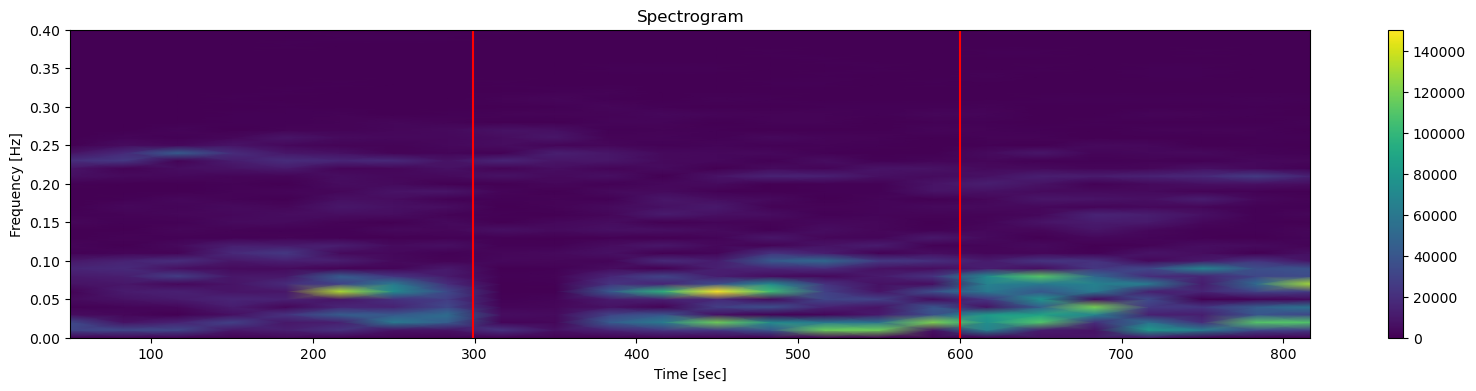

In [ ]:
#STFT RRI
nperseg = 100000
noverlap = nperseg*2/3
f1,t1,Sxx = scipy.signal.spectrogram(y_vals, fs=fs, nperseg = nperseg, noverlap = noverlap, scaling='density')
plt.figure(figsize = (20,4), dpi = 100)
plt.pcolormesh(t1, f1, np.abs(Sxx), shading='gouraud', snap= True)
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axis([t1[0], t1[-1], 0, 0.4])
plt.axvline(x = newseg1, color = 'r')
plt.axvline(x = newseg2, color = 'r')
plt.colorbar()
plt.show()